# Algorithmic Trading: Take-home Exam

Name: David Landveld

Student ID: 2742120






In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import adfuller
from cointegration_analysis import estimate_long_run_short_run_relationships, engle_granger_two_step_cointegration_test
import datetime as datetime
from scipy import stats


In [2]:
data = pd.read_csv('data.csv', index_col=0)
data.head()

,TKWY,ADYEN,KPN
fraction_of_year,,,
1.268392e-07,29.993523,74.865590,60.104009
1.902588e-07,29.978235,74.914692,60.093024
2.536783e-07,29.985092,74.938921,60.083930
3.170979e-07,29.956645,75.008993,60.093325
3.805175e-07,29.995444,75.054447,60.102438


## Question 1

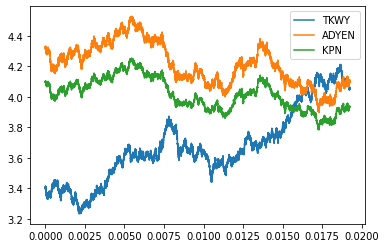

In [3]:
#Step one, transforming the data to log prices. 
logdata = np.log(data)

#plot the data
plt.plot(logdata.TKWY, label="TKWY")
plt.plot(logdata.ADYEN, label="ADYEN")
plt.plot(logdata.KPN, label="KPN")
plt.legend()

From the graphs it becomes very clear that ADYEN and KPN are cointegrated with each other, but need to test both ways to see which relationship is strongest to determine which is X and which is Y. 

In [4]:
#The stock that is cointegrated with KPN is definetly ADYEN, Lets put this to the test. 
test_X = logdata.KPN
test_Y = logdata.ADYEN

coingtegration_test1 = engle_granger_two_step_cointegration_test(test_Y,test_X)
cointegration_test2 = engle_granger_two_step_cointegration_test(test_X, test_Y)

print(coingtegration_test1)
print(cointegration_test2) 




(-174.14384272804398, 0.0)
(-174.1346423575904, 0.0)


I see that the first cointegration test with Y = ADYEN and X = KPN is just a little bit more negative, implying that the strongest cointegration relationship is attained when using this Y and X combination. So we can denote X and Y with certainty now.

In [5]:
#Denote the two stock prices by X and Y. 
X= logdata.KPN
Y = logdata.ADYEN

logdata.head(1)

,TKWY,ADYEN,KPN
fraction_of_year,,,
1.268392e-07,3.400981,4.315694,4.096077


Now I want to know the correct ratio to trade these two stocks.

In [6]:
#In order for me to find the correct ratio I need to know Gamma. 
estimator = estimate_long_run_short_run_relationships(Y,X)
c = estimator[0]
gamma = estimator[1]
alpha = estimator[2]
z = estimator[3]
print(gamma)
print(1/gamma)

1.3332954468900216
0.7500213117299321


Since I used ADYEN as Y and KPN as X, if I take a positon of 1 lot in ln(ADYEN) I will need to take a positon of -1.333 lots in ln(KPN). 
But if I have a postion of 1 log(KPN) I would need a positon of -0.75 log(ADYEN).
I assume that using ADYEN as Y also means that I will always first open a position in ADYEN and then take the counterposition in KPN.  


From this moment onwards I will be implementing the cointegration strategy. I first followed the tasks in the question and then got to do some exploring myself.

In [7]:
#Connect to the exchange
from optibook.synchronous_client import Exchange

import time
import logging
logger = logging.getLogger('client')
logger.setLevel('ERROR')

instrument_id = ['KPN', 'ADYEN', 'TKWY']

e = Exchange()
a = e.connect()

2022-03-22 22:10:10,945 [asyncio   ] [MainThread  ] Using selector: EpollSelector


In [8]:
#I used a vwap price calculator as I assume that reflects the price better than just using the midprice. 
#After that I determine the lot ratio so that I know with what volume to trade with. 
def vwap_calculator(stock) -> float:
    book = e.get_last_price_book(stock)
    if not book.bids:
        print('No bids at all for instrument.')
        price_bid = 0
        volume_bid = 0
    else:
        best_bid = book.bids[0]
        price_bid = best_bid.price
        volume_bid = best_bid.volume
    if not book.asks:
        print('No asks at all for instrument.')
        price_ask = 0
        volume_ask = 0
    else:
        best_ask = book.asks[0]
        price_ask = best_ask.price
        volume_ask = best_ask.volume    
    return ((volume_bid/(volume_bid+volume_ask) * price_bid) + (volume_ask/(volume_bid+volume_ask) * price_ask))
     
lotsizeXratio = 1*gamma*vwap_calculator('ADYEN')/vwap_calculator('KPN')

print(f'if I trade one lot Y I currently need '+"{:.4f}".format(lotsizeXratio)+' Lot X.')

if I trade one lot Y I currently need 1.5119 Lot X.


Before implementing the strategy I determined that I'd use the z-score as a trading indicator with standard deviatons from the mean as an indictor to open a position, and when the z-score gets back to the mean I close the position again. I needed to confirm that the formula used in the second graph would give me the exact same outcome as the plot for the z-scores. Because then I could use that formula to determine the current z-score of the live stocks.

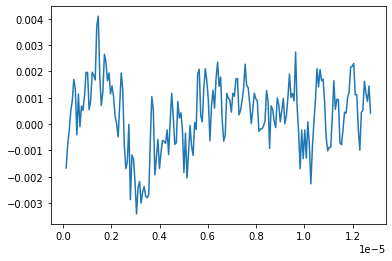

In [9]:
plt.plot(z.iloc[0:200])

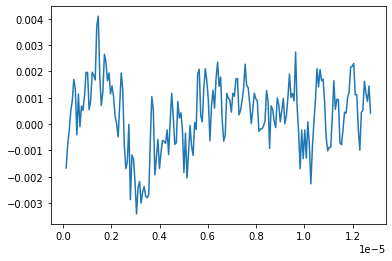

In [10]:
#y_t = c + gamma * x_t + z_t
#zt = yt - c - gamma*xt
plt.plot(logdata.ADYEN.iloc[0:200]-gamma*logdata.KPN.iloc[0:200] - c)

Below I tested out if I could get all the variables for the z-score calculations and then I put them into my functions as well. 

In [11]:
#get mean of the spread
    mean_zspread = np.mean(logdata.ADYEN-gamma*logdata.KPN - c)

    #get standard deviations on spread
    std_zspread = np.std(logdata.ADYEN-gamma*logdata.KPN - c)

    # print (mean_zspread, std_zspread)
    Upper_boundentry = mean_zspread+3*std_zspread
    Lower_boundentry =  mean_zspread-3*std_zspread

### trading

I created the following function to be able to trade on cointegration. I made sure to close all the outstanding orders, get the current z-score and my positions for information on tradability. 

I determined that the volume could be calculate by looking at how much volume was in the orderbook, then optimizing the volume so that both ADYEN and KPN orders could go trough against that volume. 

After the first tests I saw that the function 'opencointegrationtrade' was not profitable. I determined to widen the entry levels, this still not ended up profitable and in the end I discarded the first function and replaced it by the second one below it. the difference is that the second one uses a higher upper and lower lower limit for entry signals. This resulted in less frequently trading, but unfortunately the strategy remained unprofitable.

I made sure to use enough comments to explain the steps I took. 

In [12]:
def opencointegrationtrade():
    #So it becomes clear that we can use the spread as a trading signal. We need the average spread of the log prices and then two or one 
    #standard deviation from the mean as trading signal. 
    # print (mean_zspread, std_zspread)
    Upper_boundentry = mean_zspread+std_zspread
    Lower_boundentry =  mean_zspread-std_zspread
    #get zspread of current prices. 
    current_zspread = np.log(vwap_calculator('ADYEN'))-gamma*np.log(vwap_calculator('KPN'))-c
    #get postion information
    positions = e.get_positions()
    #set outstanding orders to 0
    for i in instrument_id:
        outstanding = e.get_outstanding_orders(i)
        for o in outstanding.values():
            result = e.delete_order(i, order_id=o.order_id)
            print(f"Deleted order id {o.order_id}: {result}")

    #If there is a deviation in the long run equation. So trade when z-score is above given level. lets say one time sigma of mean. 
    #determine which one to long and which one to short. if the spread is positive than adyen is relatively high and
    #kpn relatively low, so short adyen en long kpn with respective ratio.
    if current_zspread <= Lower_boundentry:
        #fetch most updated prices & volumes, bids of adyen because want to buy adyne, asks of kpn because want to short kpn. 
        bookY = e.get_last_price_book("ADYEN")
        if bookY== None:
            print('No bids at all for instrument.')
        else:
            best_bid = bookY.bids[0]
            price_bid = best_bid.price
            volume_bid = best_bid.volume
        bookX = e.get_last_price_book("KPN")
        if bookX==None:
            print('No asks at all for instrument.')
        else:
            best_ask = bookX.asks[0]
            price_ask = best_ask.price
            volume_ask = best_ask.volume 

        ratio =  lotsizeXratio
        #figure out volumes, I assume that the ration is always positive. 
        if volume_bid<=volume_ask:
            base_volumeY = volume_bid
            ratio_volumeX = int(round(volume_bid*ratio,0))
            if ratio_volumeX <= volume_ask:
                #check if trading breaks rules
                if positions["ADYEN"] + 1*int(base_volumeY) <200 and positions["KPN"] + -1*ratio_volumeX >-200 and base_volumeY<400 and ratio_volumeX<400:
                    #execute orders  
                    #short adyen ### Can go +1 on and -1 on ask to make sure you get filled. This may cause the profitability to decrease. 
                    #To solve this I should have calcultated the potential profit even with a bigger spread and if it is negative, do not trade.
                    e.insert_order("ADYEN", price=price_bid+0.1, volume=base_volumeY, side='bid', order_type='ioc') 
                    #Buy kpn      
                    e.insert_order("KPN", price=price_ask-0.1, volume=ratio_volumeX, side='ask', order_type='ioc')
            else:
                base_volumeY = int(round(volume_ask/ratio,0))
                ratio_volumeX = volume_ask
                #check if trading breaks rules
                if positions["ADYEN"] + 1*int(base_volumeY) <200 and positions["KPN"] + -1*ratio_volumeX >-200 and base_volumeY<400 and ratio_volumeX<400:
                    #execute
                    #short adyen
                    e.insert_order("ADYEN", price=price_bid+0.1, volume=base_volumeY, side='bid', order_type='ioc') 
                    #Buy kpn      
                    e.insert_order("KPN", price=price_ask-0.1, volume=ratio_volumeX, side='ask', order_type='ioc')
        else: 
            base_volumeY = int(round(volume_ask/ratio,0))
            ratio_volumeX = volume_ask
            #check if trading breaks rules
            if positions["ADYEN"] + 1*int(base_volumeY) <200 and positions["KPN"] + -1*ratio_volumeX >-200 and base_volumeY<400 and ratio_volumeX<400:
                #execute orders  
                #short adyen
                e.insert_order("ADYEN", price=price_bid+0.1, volume=base_volumeY, side='bid', order_type='ioc') 
                #Buy kpn      
                e.insert_order("KPN", price=price_ask-0.1, volume=ratio_volumeX, side='ask', order_type='ioc')


        #calculate positon ratios.

        #short adyen, aim for the bid order

        #long kpn, aim for the ask orders.

    elif current_zspread>= Upper_boundentry:
         #fetch most updated prices & volumes, asks of adyen because now we need to go short, bids of kpn because we need to buy it. 
        bookX = e.get_last_price_book("KPN")
        if bookX == None:
            print('No bids at all for instrument.')
        else:
            best_bid = bookX.bids[0]
            price_bid = best_bid.price
            volume_bid = best_bid.volume
        bookY = e.get_last_price_book("ADYEN")
        if bookY == None:
            print('No asks at all for instrument.')
        else:
            best_ask = bookY.asks[0]
            price_ask = best_ask.price
            volume_ask = best_ask.volume 
        ratio =  lotsizeXratio
        #figure out volumes
        if volume_ask<=volume_bid:
            base_volumeY = volume_ask
            ratio_volumeX = int(round(volume_ask*ratio,0))
            if ratio_volumeX <= volume_bid:
                #check if trading breaks rules
                if positions["ADYEN"] + -1*int(base_volumeY) >-200 and positions["KPN"] + ratio_volumeX <200 and base_volumeY<400 and ratio_volumeX<400:
                    #execute orders  
                    #short adyen ### Can go +1 on and -1 on ask to make sure you get filled. This may cause the profitability to decrease. 
                    #To solve this I should have calcultated the potential profit even with a bigger spread and if it is negative, do not trade.
                    e.insert_order("ADYEN", price=price_ask-0.1, volume=base_volumeY, side='ask', order_type='ioc') 
                    #Buy kpn      
                    e.insert_order("KPN", price=price_bid+0.1, volume=ratio_volumeX, side='bid', order_type='ioc')
            else:
                base_volumeY = int(round(volume_bid/ratio,0))
                ratio_volumeX = volume_bid
                #check if trading breaks rules
                if positions["ADYEN"] + -1*int(base_volumeY) >-200 and positions["KPN"] + ratio_volumeX <200 and base_volumeY<400 and ratio_volumeX<400:
                    #execute
                    #short adyen
                    e.insert_order("ADYEN", price=price_ask-0.1, volume=base_volumeY, side='ask', order_type='ioc') 
                    #Buy kpn      
                    e.insert_order("KPN", price=price_bid+0.1, volume=ratio_volumeX, side='bid', order_type='ioc')
        else: 
            base_volumeY = int(round(volume_ask/ratio,0))
            ratio_volumeX = volume_ask
            #check if trading breaks rules
            if positions["ADYEN"] + -1*int(base_volumeY) >-200 and positions["KPN"] + ratio_volumeX <200 and base_volumeY<400 and ratio_volumeX<400:
                #execute orders  
                #short adyen
                e.insert_order("ADYEN", price=price_ask-0.1, volume=base_volumeY, side='ask', order_type='ioc') 
                #Buy kpn      
                e.insert_order("KPN", price=price_bid+0.1, volume=ratio_volumeX, side='bid', order_type='ioc')



            #fetch most updated prices

            #calculate positon ratios.

            #long adyen

            #short kpn.

    #Get most recent prices.

    #Trade on the most recent prices with the right directions. 

    # When trading on Optibook, you are not allowed to cross the following predefined limits:
    # - Total position (long or short) per instrument may not be more than 200
    # - Total outstanding (pending) orders may not be more than 400 lots per instrument
    # - The maximum number of updates (inserts/deletes/amends) which are sent to the market may not be 
    # more than 25 updates per second

In [13]:
def twosigmaopencointegrationtrade():
    #So it becomes clear that we can use the spread as a trading signal. We need the average spread of the log prices and then two or one 
    #standard deviation from the mean as trading signal. 

    #get mean of the spread
    mean_zspread = np.mean(logdata.ADYEN-gamma*logdata.KPN - c)

    #get standard deviations on spread
    std_zspread = np.std(logdata.ADYEN-gamma*logdata.KPN - c)

    # print (mean_zspread, std_zspread)
    Upper_boundentry = mean_zspread+3*std_zspread
    Lower_boundentry =  mean_zspread-3*std_zspread
    #get zspread of current prices. 
    current_zspread = np.log(vwap_calculator('ADYEN'))-gamma*np.log(vwap_calculator('KPN'))-c
    #get postion information
    positions = e.get_positions()
    #set outstanding orders to 0
    for i in instrument_id:
        outstanding = e.get_outstanding_orders(i)
        for o in outstanding.values():
            result = e.delete_order(i, order_id=o.order_id)
            print(f"Deleted order id {o.order_id}: {result}")

    #If there is a deviation in the long run equation. So trade when z-score is above given level. lets say one time sigma of mean. 
    #determine which one to long and which one to short. if the spread is positive than adyen is relatively high and
    #kpn relatively low, so short adyen en long kpn with respective ratio.
    if current_zspread <= Lower_boundentry:
        #fetch most updated prices & volumes, bids of adyen because want to buy adyne, asks of kpn because want to short kpn. 
        bookY = e.get_last_price_book("ADYEN")
        if bookY== None:
            print('No bids at all for instrument.')
        else:
            best_bid = bookY.bids[0]
            price_bid = best_bid.price
            volume_bid = best_bid.volume
        bookX = e.get_last_price_book("KPN")
        if bookX==None:
            print('No asks at all for instrument.')
        else:
            best_ask = bookX.asks[0]
            price_ask = best_ask.price
            volume_ask = best_ask.volume 

        ratio =  lotsizeXratio
        #figure out volumes, I assume that the ration is always positive. 
        if volume_bid<=volume_ask:
            base_volumeY = volume_bid
            ratio_volumeX = int(round(volume_bid*ratio,0))
            if ratio_volumeX <= volume_ask:
                #check if trading breaks rules
                if positions["ADYEN"] + 1*int(base_volumeY) <200 and positions["KPN"] + -1*ratio_volumeX >-200 and base_volumeY<400 and ratio_volumeX<400:
                    #execute orders  
                    #short adyen ### Can go +1 on and -1 on ask to make sure you get filled. This may cause the profitability to decrease. 
                    #To solve this I should have calcultated the potential profit even with a bigger spread and if it is negative, do not trade.
                    e.insert_order("ADYEN", price=price_bid+1, volume=base_volumeY, side='bid', order_type='ioc') 
                    #Buy kpn      
                    e.insert_order("KPN", price=price_ask-1, volume=ratio_volumeX, side='ask', order_type='ioc')
            else:
                base_volumeY = int(round(volume_ask/ratio,0))
                ratio_volumeX = volume_ask
                #check if trading breaks rules
                if positions["ADYEN"] + 1*int(base_volumeY) <200 and positions["KPN"] + -1*ratio_volumeX >-200 and base_volumeY<400 and ratio_volumeX<400:
                    #execute
                    #short adyen
                    e.insert_order("ADYEN", price=price_bid+1, volume=base_volumeY, side='bid', order_type='ioc') 
                    #Buy kpn      
                    e.insert_order("KPN", price=price_ask-1, volume=ratio_volumeX, side='ask', order_type='ioc')
        else: 
            base_volumeY = int(round(volume_ask/ratio,0))
            ratio_volumeX = volume_ask
            #check if trading breaks rules
            if positions["ADYEN"] + 1*int(base_volumeY) <200 and positions["KPN"] + -1*ratio_volumeX >-200 and base_volumeY<400 and ratio_volumeX<400:
                #execute orders  
                #short adyen
                e.insert_order("ADYEN", price=price_bid+1, volume=base_volumeY, side='bid', order_type='ioc') 
                #Buy kpn      
                e.insert_order("KPN", price=price_ask-1, volume=ratio_volumeX, side='ask', order_type='ioc')


        #calculate positon ratios.

        #short adyen, aim for the bid order

        #long kpn, aim for the ask orders.

    elif current_zspread>= Upper_boundentry:
         #fetch most updated prices & volumes, asks of adyen because now we need to go short, bids of kpn because we need to buy it. 
        bookX = e.get_last_price_book("KPN")
        if bookX == None:
            print('No bids at all for instrument.')
        else:
            best_bid = bookX.bids[0]
            price_bid = best_bid.price
            volume_bid = best_bid.volume
        bookY = e.get_last_price_book("ADYEN")
        if bookY == None:
            print('No asks at all for instrument.')
        else:
            best_ask = bookY.asks[0]
            price_ask = best_ask.price
            volume_ask = best_ask.volume 
        ratio =  lotsizeXratio
        #figure out volumes
        if volume_ask<=volume_bid:
            base_volumeY = volume_ask
            ratio_volumeX = int(round(volume_ask*ratio,0))
            if ratio_volumeX <= volume_bid:
                #check if trading breaks rules
                if positions["ADYEN"] + -1*int(base_volumeY) >-200 and positions["KPN"] + ratio_volumeX <200 and base_volumeY<400 and ratio_volumeX<400:
                    #execute orders  
                    #short adyen ### Can go +1 on and -1 on ask to make sure you get filled. This may cause the profitability to decrease. 
                    #To solve this I should have calcultated the potential profit even with a bigger spread and if it is negative, do not trade.
                    e.insert_order("ADYEN", price=price_ask-1, volume=base_volumeY, side='ask', order_type='ioc') 
                    #Buy kpn      
                    e.insert_order("KPN", price=price_bid+1, volume=ratio_volumeX, side='bid', order_type='ioc')
            else:
                base_volumeY = int(round(volume_bid/ratio,0))
                ratio_volumeX = volume_bid
                #check if trading breaks rules
                if positions["ADYEN"] + -1*int(base_volumeY) >-200 and positions["KPN"] + ratio_volumeX <200 and base_volumeY<400 and ratio_volumeX<400:
                    #execute
                    #short adyen
                    e.insert_order("ADYEN", price=price_ask-1, volume=base_volumeY, side='ask', order_type='ioc') 
                    #Buy kpn      
                    e.insert_order("KPN", price=price_bid+1, volume=ratio_volumeX, side='bid', order_type='ioc')
        else: 
            base_volumeY = int(round(volume_ask/ratio,0))
            ratio_volumeX = volume_ask
            #check if trading breaks rules
            if positions["ADYEN"] + -1*int(base_volumeY) >-200 and positions["KPN"] + ratio_volumeX <200 and base_volumeY<400 and ratio_volumeX<400:
                #execute orders  
                #short adyen
                e.insert_order("ADYEN", price=price_ask-1, volume=base_volumeY, side='ask', order_type='ioc') 
                #Buy kpn      
                e.insert_order("KPN", price=price_bid+1, volume=ratio_volumeX, side='bid', order_type='ioc')



            #fetch most updated prices

            #calculate positon ratios.

            #long adyen

            #short kpn.

    #Get most recent prices.

    #Trade on the most recent prices with the right directions. 

    # When trading on Optibook, you are not allowed to cross the following predefined limits:
    # - Total position (long or short) per instrument may not be more than 200
    # - Total outstanding (pending) orders may not be more than 400 lots per instrument
    # - The maximum number of updates (inserts/deletes/amends) which are sent to the market may not be 
    # more than 25 updates per second

Now I needed to make sure that I could unwind my position as soon as the z-score got back to the mean z-score again.

I tested it also with using the reverse of the upper and lower bounds as exits. This would in theory make it so that a lot of profit has been captured.
In practice I kept about as unprofitable as before though. 

In [14]:
def unwinder():
    Upper_boundentry = mean_zspread+2.9*std_zspread
    Lower_boundentry =  mean_zspread-2.9*std_zspread
    positions = e.get_positions()
    current_zspread = np.log(vwap_calculator('ADYEN'))-gamma*np.log(vwap_calculator('KPN'))-c
    if positions["ADYEN"]>0 and current_zspread>=Upper_boundentry: #Here we need to sell adyen and buy kpn. In this case I should have profited a lot from the difference in spread.
        #get closest prices. 
        bookX = e.get_last_price_book("KPN")
        if bookX == None:
            print('No bids at all for instrument.')
        else:
            best_bid = bookX.bids[0]
            price_bid = best_bid.price
            volume_bid = best_bid.volume
        bookY = e.get_last_price_book("ADYEN")
        if bookY == None:
            print('No asks at all for instrument.')
        else:
            best_ask = bookY.asks[0]
            price_ask = best_ask.price
            volume_ask = best_ask.volume 
        for s, p in e.get_positions().items():
            if p > 0:
                e.insert_order(s, price=price_ask-1, volume=p, side='ask', order_type='ioc')
            elif p < 0:
                e.insert_order(s, price=price_bid+1, volume=-p, side='bid', order_type='ioc')
            time.sleep(0.10)
        positions = e.get_positions()
        print(f'\nPnL after: {e.get_pnl():.2f}')
    # And do vice versa.
    if positions["ADYEN"]<0 and current_zspread<=Lower_boundentry: 
        bookY = e.get_last_price_book("ADYEN")
        if bookY== None:
            print('No bids at all for instrument.')
        else:
            best_bid = bookY.bids[0]
            price_bid = best_bid.price
            volume_bid = best_bid.volume
        bookX = e.get_last_price_book("KPN")
        if bookX==None:
            print('No asks at all for instrument.')
        else:
            best_ask = bookX.asks[0]
            price_ask = best_ask.price
            volume_ask = best_ask.volume 
        for s, p in e.get_positions().items():
            if p > 0:
                e.insert_order(s, price=price_ask-1, volume=p, side='ask', order_type='ioc')
            elif p < 0:
                e.insert_order(s, price=price_bid+1, volume=-p, side='bid', order_type='ioc')
            time.sleep(0.10)
        print(f'\nPnL after: {e.get_pnl():.2f}')
    

In [15]:
def showpositionandcash():
    # Returns postions with cash component
    positions = e.get_positions_and_cash()
    for iid in instrument_id:
        print(f'''{iid:18s}: {positions[iid]['volume']:3.0f} position, {positions[iid]['cash']:10.2f} cash''')

In [16]:
# while True: 
#     try: 
#         twosigmaopencointegrationtrade()
#         unwinder()
#     except:
#         pass

### Concluding

I did not mange to make this strategy profitable, but at least after many hours of trying it ran. 

The most proift I lost, of which I was aware was an hourly pnl was -25k.

## Question 2

As so far I have found that the strategy I used for cointegration did not yield in profits, I will absolutely not use it for this question.


### Strategies
1. Make a market in options as we did in assignment 1.


2. Use limit orders that will execute against ioc orders that use prices that are a considerable amount below or above the fair price, which other people use to close out their positons.



In [17]:
# connect
from optibook.synchronous_client import Exchange
import time
import logging
logger = logging.getLogger('client')
logger.setLevel('ERROR')
import datetime
import datetime as dt
from scipy import stats
import numpy as np

In [18]:
# Calculate the historical volatility for each stock. 
def historic_volatility(stock):
    price = data[stock]
    r = np.diff(np.log(price))
    r_mean = np.mean(r)
    diff_square = [(r[i]-r_mean)**2 for i in range(0,len(r))]
    std = np.sqrt(sum(diff_square)*(1.0/(len(r)-1)))
    vol = std*np.sqrt(252)
    return vol
vola_ADYEN = historic_volatility("ADYEN")
vola_KPN = historic_volatility("KPN")
vola_TKWY = historic_volatility("TKWY")

from scipy import stats
import numpy as np
import datetime as dt


_norm_cdf = stats.norm(0, 1).cdf
_norm_pdf = stats.norm(0, 1).pdf


print(vola_ADYEN, vola_KPN, vola_TKWY)

0.014005214112555306 0.003979401829485913 0.013976298802220573


In [19]:
# Here I will show all the possible functions I can use. 
def deleteoutstanding(instrument_id): #instrument_id should be a list. 
    for i in instrument_id:
        outstanding = e.get_outstanding_orders(i)
        for o in outstanding.values():
            result = e.delete_order(instrument_id, order_id=o.order_id)
            
def calculate_time_to_date(expiry_date, current_time) -> float:
    return (expiry_date - current_time) / dt.timedelta(days=1) / 365

def calculate_current_time_to_date(expiry_date) -> float:
    now = dt.datetime.now()
    return calculate_time_to_date(expiry_date, now)
 
def _d1(S, K, T, r, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


def _d2(S, K, T, r, sigma):
    return _d1(S, K, T, r, sigma) - sigma * np.sqrt(T)

def call_value(S, K, T, r, sigma):
    return S * _norm_cdf(_d1(S, K, T, r, sigma)) - K * np.exp(-r * T) * _norm_cdf(
        _d2(S, K, T, r, sigma)
    )
def put_value(S, K, T, r, sigma):
    return np.exp(-r * T) * K * _norm_cdf(-_d2(S, K, T, r, sigma)) - S * _norm_cdf(
        -_d1(S, K, T, r, sigma)
    )
    
def fairpricecalculator(instrument_id):
    Option_values = [] 
    aa = 0
    b = 0
    for i in instrument_id:
        book = e.get_last_price_book(i)
        if book == None:
            print('No bids at all for instrument.')
        else:
            best_bid = book.bids[0]
            price = best_bid.price
            volume = best_bid.volume
            # Store the bid price
            aa= price
            # print(f'Best bid is {volume} lots @ price {price:.2f}.')

        if book == None:
            print('No asks at all for instrument.')
        else:
            best_ask = book.asks[0]
            price = best_ask.price
            volume = best_ask.volume
            # print(f'Best ask is {volume} lots @ price {price:.2f}.')
            # Store the ask price
            b = price
        #calculate average price we call it 'S' as it is called in the black scholes formula.
        
        S = (aa +b)/2
        # print(f'The average price of BMW is {S:.2f}.')
        r = 0.0
        sigma= historic_volatility(i)
        #FIX THE DATES
        expiry_date = dt.datetime(2022, 4, 29, 12, 0, 0)
        now = dt.datetime.now()
        T = calculate_time_to_date(expiry_date, now)
        _norm_cdf = stats.norm(0, 1).cdf
        _norm_pdf = stats.norm(0, 1).pdf
        if i == "ADYEN" or i == "KPN":
            K_list = [50,75,100] 
        else: 
            K_list = [20,30,40]
        
        for j in K_list:
            call_price = call_value(S,j,T,r,sigma) 
            # print(S, j, T, r, sigma,call_price)
            Option_values.append(call_price)
            put_price = put_value(S,j,T,r,sigma)
            # print(j,put_price)
            Option_values.append(put_price)
    return Option_values

#A function that I use for rounding. 
def myround(x, prec=2, base=.1):
    return round(base * round(float(x)/base),prec)
def call_delta(S, K, T, r, sigma):
    return _norm_cdf(_d1(S, K, T, r, sigma))
def put_delta(S, K, T, r, sigma):
    return call_delta(S, K, T, r, sigma) - 1
instrument_id = ["ADYEN", "KPN", "TKWY"] #put in eventual strat def. 

def myroundwhole(x, prec=2, base=1):
    return round(base * round(float(x)/base),prec)

def bidask_order_and_hedge(instrument_id):
    id_list_A =  ["ADYEN-2022_04_29-050C","ADYEN-2022_04_29-050P", "ADYEN-2022_04_29-075C", "ADYEN-2022_04_29-075P", "ADYEN-2022_04_29-100C", "ADYEN-2022_04_29-100P"]
    id_list_K = ["KPN-2022_04_29-050C","KPN-2022_04_29-050P", "KPN-2022_04_29-075C", "KPN-2022_04_29-075P", "KPN-2022_04_29-100C", "KPN-2022_04_29-100P"]
    id_list_T = ["TKWY-2022_04_29-020C","TKWY-2022_04_29-020P", "TKWY-2022_04_29-030C", "TKWY-2022_04_29-030P", "TKWY-2022_04_29-040C", "TKWY-2022_04_29-040P"]   
    id_list = id_list_A+id_list_K+id_list_T
    for i in instrument_id:
        instrument_id = i
        e = Exchange()
        a = e.connect()
        #get the positions
        positions = e.get_positions_and_cash()
        positions_list3 = []
        for iid in sorted(positions):
            if iid == 'ADYEN' or iid == "KPN" or iid == "TKWY":
                continue
            # print(f'''{iid:18s}: {positions[iid]['volume']:3.0f} position, {positions[iid]['cash']:10.2f} cash''')
            positions_list3.append(positions[iid]['volume'])#So first does adyen, then kpn, then tkwy. 7 each

        fairpricecalculator(instrument_id)
        #Here we make sure to insert the orders into the market, taking into account the different volumes of our positions as decribed in the report.
        #add total hedgeA/K/T <200 then trade.
        for i in range(len(Option_values)): #len = 18
            # print (Option_values[i])
            # print(id_list[i])
            if myround(Option_values[i]) >= Option_values[i] and 50-abs(positions_list3[i]) >0 and myround(Option_values[i]) != 0.0:
                #Then rounded upwards so Options_values[i] is the ask.
                ask = myround(Option_values[i])
                bid = myround(Option_values[i]-0.1)
                result = e.insert_order(id_list[i], price=bid, volume=50-abs(positions_list3[1:][i]), side='bid', order_type='limit') # bid gives us a positive position, so we go long. 
                # print(f"Order Id: {result}")
                result = e.insert_order(id_list[i], price=ask, volume=50-abs(positions_list3[1:][i]), side='ask', order_type='limit') # ask gives us a negative position, so we go short.
                # print(f"Order Id: {result}")

            elif myround(Option_values[i]) >= Option_values[i] and 50-positions_list3[1:][i] ==-50 and myround(Option_values[i]) != 0.0:
                ask = myround(Option_values[i])
                bid = myround(Option_values[i]-0.1)
                result = e.insert_order(id_list[i], price=ask, volume=50, side='ask', order_type='limit')
                # print(f"Order Id: {result}")
            elif myround(Option_values[i]) >= Option_values[i] and 50-positions_list3[1:][i] ==150 and myround(Option_values[i]) != 0.0:   
                ask = myround(Option_values[i]-0.1)
                bid = myround(Option_values[i])
                result = e.insert_order(id_list[i], price=bid, volume=50, side='bid', order_type='limit')
                # print(f"Order Id: {result}")

            elif  myround(Option_values[i]) < Option_values[i] and 50-abs(positions_list3[1:][i]) >0 and myround(Option_values[i]) != 0.0: #Then rounded downwards so options_vlaues[i] is the bid.
                ask = myround(Option_values[i]+0.1)
                bid = myround(Option_values[i])
                result = e.insert_order(id_list[i], price=bid, volume=50-abs(positions_list3[1:][i]), side='bid', order_type='limit')
                # print(f"Order Id: {result}")
                result = e.insert_order(id_list[i], price=ask, volume=50-abs(positions_list3[1:][i]), side='ask', order_type='limit')
                # print(f"Order Id: {result}")
            elif  myround(Option_values[i]) < Option_values[i] and 50-(positions_list3[1:][i]) ==-50 and myround(Option_values[i]) != 0.0:
                ask = myround(Option_values[i]+0.1)
                bid = myround(Option_values[i])
                result = e.insert_order(id_list[i], price=ask, volume=50, side='ask', order_type='limit')
                # print(f"Order Id: {result}")
            elif  myround(Option_values[i]) < Option_values[i] and 50-(positions_list3[1:][i]) ==150 and myround(Option_values[i]) != 0.0:
                ask = myround(Option_values[i]+0.1)
                bid = myround(Option_values[i])
                result = e.insert_order(id_list[i], price=bid, volume=50, side='bid', order_type='limit')
                # print(f"Order Id: {result}")

        #Hedging, here our calculations for the delta start, together with how many stocks long or short we need to be in order to be hedged.

        # Returns postions with cash component
        positions = e.get_positions_and_cash()
        positions_list = []
        for iid in sorted(positions):
            if iid == 'ADYEN' or iid == "KPN" or iid == "TKWY":
                continue
            # print(f'''{iid:18s}: {positions[iid]['volume']:3.0f} position, {positions[iid]['cash']:10.2f} cash''')
            positions_list.append(positions[iid]['volume'])
        positions_list_stocks = []
        for iid in sorted(positions):
            if iid == 'ADYEN' or iid == "KPN" or iid == "TKWY":
                positions_list_stocks.append(positions[iid]['volume'])

        m= call_delta(S,K,T,r,sigma)#test
        n= put_delta(S,K,T,r,sigma)#test

        Delta_values = [] #first receives all the calls and then put prices.
        # call_delta_values = []
        # put_delta_values = []
        allK_list = [50,75,100,50,75,100,20,30,40]
        for i in allK_list:
            call_deltas = call_delta(S,i,T,r,sigma) 
            Delta_values.append(call_deltas)
            put_deltas = put_delta(S,i,T,r,sigma)
            Delta_values.append(put_deltas) 
        # Delta_values = call_delta_values + put_delta_values
        
        
        testhedge_options = []
        position_listA = positions_list[0:6]
        position_listK = positions_list[6:12]
        position_listT = positions_list[12:18]
        for num1, num2 in zip(Delta_values[0:6], position_listA):
            # print(num1,num2)
            testhedge_options.append(num1 * num2)
        for num1, num2 in zip(Delta_values[6:12], position_listK):
            # print(num1,num2)
            testhedge_options.append(num1 * num2)
        for num1, num2 in zip(Delta_values[12:18], position_listT):
            # print(num1,num2)
            testhedge_options.append(num1 * num2)
        #
        total_hedgeA= myroundwhole(sum(testhedge_options[0:6])-positions_list_stocks[0:1])
        total_hedgeK= myroundwhole(sum(testhedge_options[6:12])-positions_list_stocks[1:2])
        total_hedgeT= myroundwhole(sum(testhedge_options[12:18])-positions_list_stocks[2:3])

        if total_hedgeA >= 200: 
            total_hedgeA = 200.
        if total_hedgeA <=-200: 
            total_hedgeA =-200  
        if total_hedgeK >= 200: 
            total_hedgeK = 200.
        if total_hedgeK <=-200: 
            total_hedgeK =-200 
        if total_hedgeT >= 200: 
            total_hedgeT = 200.
        if total_hedgeT <=-200: 
            total_hedgeT =-200 
        
            # print(sum(testhedge_options),total_hedge)    
            # If we need to short, get bid price and execute ioc with bid price.
        for i in instrument_id:
            book = e.get_last_price_book(i)
            if book == None:
                print('No bids at all for instrument.')
            else:
                best_bid = book.bids[0]
                price = best_bid.price
                volume = best_bid.volume
                # Store the bid price
                aa= round(price,2)
                # print(f'Best bid is {volume} lots @ price {price:.2f}.')
            if book == None:
                print('No asks at all for instrument.')
            else:
                best_ask = book.asks[0]
                price = best_ask.price
                volume = best_ask.volume
                # print(f'Best ask is {volume} lots @ price {price:.2f}.')
                # Store the ask price
                b = round(price,2)
            if i == "ADYEN":
                total_hedge = total_hedgeA 
                positions_list = positions_list_stocks[0:1]
            elif i == "KPN":
                total_hedge = total_hedgeK
                positions_list= positions_list_stocks[1:2]
            else: 
                total_hedge = total_hedgeT
                positions_list= positions_list_stocks[2:3]
            #do the hedge    
            if total_hedge >0:# and 200-positions_list[0]-abs(total_hedge)>0:# we need to short the instrument
                # Insert ask IOC - This can trade against any resting volume but does not remain in the book
                result = e.insert_order(i, price=aa+0.2, volume=abs(total_hedge), side='bid', order_type='ioc')
                # print(f"Order Id: {result}")
                #if we need to long, get ask price and execute ioc with ask price.
            elif total_hedge <0:# and 200 - positions_list[0]  - abs(total_hedge) >0: #we need to go long in the instrument.
                # Insert ask IOC - This can trade against any resting volume but does not remain in the book
                result = e.insert_order(i, price=b-0.2, volume=abs(total_hedge), side='ask', order_type='ioc')
                # print(f"Order Id: {result}")

        #Finally we print our positions at the end of the loop to quickly check if we trade, without having to go to the visualizer portal.     
        positions = e.get_positions_and_cash()
        positions_list2 = []
        for iid in sorted(positions):
            print(f'''{iid:18s}: {positions[iid]['volume']:3.0f} position, {positions[iid]['cash']:10.2f} cash''')
            positions_list2.append(positions[iid]['volume'])
        print(positions_list2)

In [21]:
def MarketCruiserDavid(instrument_id):
    deleteoutstanding(instrument_id)
    bidask_order_and_hedge(instrument_id)

In [22]:
# connect
from optibook.synchronous_client import Exchange
import time
import logging
logger = logging.getLogger('client')
logger.setLevel('ERROR')
import datetime
import datetime as dt
from scipy import stats
import numpy as np

# e = Exchange()
# a = e.connect()


instrument_id = ["ADYEN", "KPN", "TKWY"]
while True:
    # try:
    MarketCruiserDavid(instrument_id)
    # except:
    #     pass

2022-03-22 22:10:12,353 [asyncio   ] [MainThread  ] Using selector: EpollSelector


No bids at all for instrument.
No asks at all for instrument.


2022-03-22 22:10:12,475 [client    ] [Thread-4    ] Forcing a disconnect due to an error: Closing connection because someone else logged in with the same credentials. Only one session may be active at the same time.


KeyError: 'A'

## to do:

Turn on the strategy of question 1
final things to change: Make sure that the options take their deltas into consideration when trading so that you'd never trade once your delta becomes a certain number. Then only the hedging and trades on the other side would resolve the delta exposure automatically. 

## Final remarks question 2

The code is not running while I believe it should. I had no more time to figure out why. 